## ALL Model

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step

LightGBM モデルの評価指標（Log Returnベース）:
 - MSE（平均二乗誤差）        : 0.00568852
 - RMSE（平方平均二乗誤差）   : 0.07542230
 - MAE（平均絶対誤差）        : 0.02332155
 - MAPE（平均絶対パーセント誤差）: 4.25 %
 - R²（決定係数）             : 0.99211849

XGBoost モデルの評価指標（Log Returnベース）:
 - MSE（平均二乗誤差）        : 0.00022755
 - RMSE（平方平均二乗誤差）   : 0.01508482
 - MAE（平均絶対誤差）        : 0.00778582
 - MAPE（平均絶対パーセント誤差）: 1.69 %
 - R²（決定係数）             : 0.99968472

RandomForest モデルの評価指標（Log Returnベース）:
 - MSE（平均二乗誤差）        : 0.00000661
 - RMSE（平方平均二乗誤差）   : 0.00257053
 - MAE（平均絶対誤差）        : 0.00126219
 - MAPE（平均絶対パーセント誤差）: 0.20 %
 - R²（決定係数）             : 0.99999085

LSTM モデルの評価指標（Log Returnベース）:
 - MSE（平均二乗誤差）        : 0.06509431
 - RMSE（平方平均二乗誤差）   : 0.25513587
 - MAE（平均絶対誤差）        : 0.24411784
 - MAPE（平均絶対パーセント誤差）: 126.77 %
 - R²（決定係数）             : 0.90981111

ARIMA モデルの評価指標（Log Returnベース）:
 - MSE（平均二乗誤差）        : 0.73788471
 - RMSE（平方平均二乗誤差）   : 0.85900216
 - MAE（平均絶対誤差）        : 0.61923504
 - MAPE（平

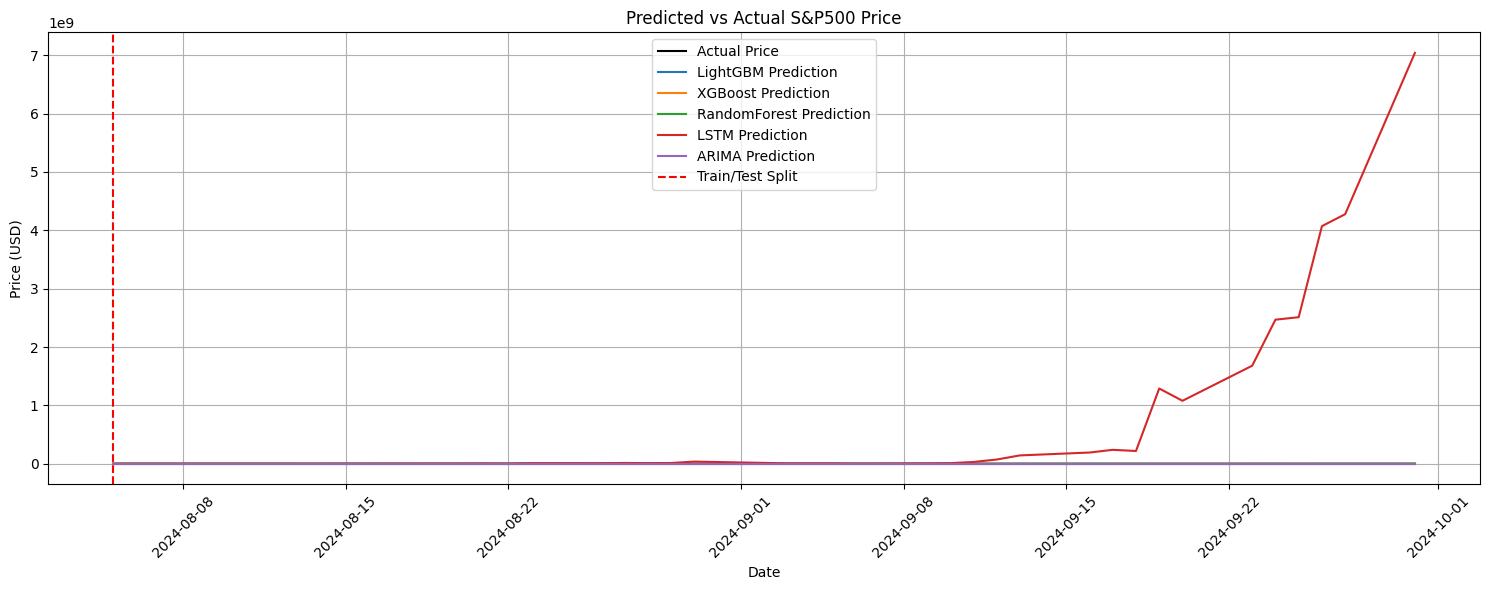

In [1]:
# ---------- 必要なライブラリをColab上でインストール（初回のみ） ----------
!pip install yfinance lightgbm xgboost tensorflow statsmodels -q

# ---------- 各種ライブラリの読み込み ----------
import yfinance as yf  # Yahoo Finance APIを使って株価データを取得
import numpy as np  # 数値計算ライブラリ（行列演算や数学的処理に使用）
import pandas as pd  # データ解析ライブラリ（表形式データの処理に使用）
import warnings  # Pythonの警告を制御（不要な警告を無視するため）
from sklearn.preprocessing import StandardScaler  # データの標準化（スケールを揃える）
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # モデルの評価指標
from sklearn.ensemble import RandomForestRegressor  # ランダムフォレスト（決定木ベースの機械学習モデル）
import lightgbm as lgb  # LightGBM（勾配ブースティングモデル、計算が高速）
import xgboost as xgb  # XGBoost（勾配ブースティングモデル、高精度）
from statsmodels.tsa.arima.model import ARIMA  # ARIMA（時系列予測モデル）
from tensorflow.keras.models import Sequential  # LSTM（ニューラルネットワークモデルを構築）
from tensorflow.keras.layers import LSTM, Dense, Dropout  # LSTMの各層
import tensorflow as tf  # TensorFlow（ディープラーニングフレームワーク）
import matplotlib.pyplot as plt  # グラフ描画ライブラリ（データの可視化）

# ---------- 不要な警告の抑制 ----------
warnings.filterwarnings("ignore", category=FutureWarning)  # 将来の変更による警告を無視
warnings.filterwarnings("ignore", category=UserWarning)  # 一般的なユーザー警告を無視

# ---------- データ取得 ----------
data = yf.download("^GSPC", start="2016-10-01", end="2024-10-01")  # 株価データを取得
data['Log_Close'] = np.log(data['Close'])  # 終値を対数変換（変動率を扱いやすくするため）
data['Log_Return'] = data['Log_Close'].diff()  # 対数変換した終値の差分を計算
data['SMA_20'] = data['Close'].rolling(window=20).mean()  # 20日移動平均を算出（トレンドの把握）
data['RSI_14'] = 100 - (100 / (1 + data['Close'].pct_change().rolling(window=14).mean()))  # RSI（相対力指数）
data['Daily_Change'] = data['Close'].pct_change()  # 日次の変化率
data.dropna(inplace=True)  # 計算できない行を削除（NaNを取り除く）

# ---------- 特徴量の標準化 ----------
features = ['Log_Return', 'High', 'Low', 'Volume', 'SMA_20', 'RSI_14', 'Daily_Change']  # 学習に使う特徴量
scaler = StandardScaler()  # 標準化オブジェクトを作成
scaled_data = scaler.fit_transform(data[features])  # データを標準化（平均0・分散1にする）

# ---------- データ分割 ----------
train_size = int(len(scaled_data) * 0.98)  # データの98%を学習用にし、残りをテスト用に分割
X_train, X_test = scaled_data[:train_size], scaled_data[train_size:]  # 特徴量の分割
y_train, y_test = X_train[:, 0], X_test[:, 0]  # 目的変数（終値の変化率）

# ---------- モデル用データ変形 ----------
X_train_flat, X_test_flat = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)  # 形を整える

# ---------- 結果保存用の辞書 ----------
results = {}  # 各モデルの評価結果を保存
logreturn_preds = {}  # 各モデルの予測値を保存

# ---------- LightGBM ----------
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=15, verbose=-1)  # 計算が高速な回帰モデル
lgb_model.fit(X_train_flat, y_train)  # 学習を実行
logreturn_preds['LightGBM'] = lgb_model.predict(X_test_flat)  # 予測結果を保存

# ---------- XGBoost ----------
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=15, objective='reg:squarederror', verbosity=0) # 回帰モデル
xgb_model.fit(X_train_flat, y_train) # 学習を実行
logreturn_preds['XGBoost'] = xgb_model.predict(X_test_flat) # 予測結果を保存

# ---------- Random Forest ----------
rf_model = RandomForestRegressor(n_estimators=500, max_depth=15) # 回帰モデル
rf_model.fit(X_train_flat, y_train) # 学習を実行
logreturn_preds['RandomForest'] = rf_model.predict(X_test_flat) # 予測結果を保存

# ---------- LSTM ----------
tf.random.set_seed(42)  # 乱数の再現性を確保（結果を安定させる）
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # LSTM層（時間の依存関係を考慮）
    Dropout(0.2),  # 過学習を防ぐためのドロップアウト（一定割合のノードを無効化）
    LSTM(75, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),  # 活性化関数ReLUを用いた全結合層（複雑な関係を捉える）
    Dense(1)  # 最終的な出力層
])
lstm_model.compile(optimizer='adam', loss='mse')  # Adamオプティマイザを使用（収束が速く安定）
lstm_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=30, batch_size=32, verbose=0)
lstm_preds = lstm_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
logreturn_preds['LSTM'] = lstm_preds.flatten()

# ---------- ARIMA モデル ----------
arima_model = ARIMA(data['Log_Return'][:train_size], order=(5,1,0))  # ARIMAモデル（時系列データの傾向を捉える）
arima_fit = arima_model.fit()
arima_preds = arima_fit.forecast(steps=len(X_test))
logreturn_preds['ARIMA'] = arima_preds.values

# ---------- 評価指標の計算 ----------
for model, preds in logreturn_preds.items():
    mse = mean_squared_error(y_test, preds)  # MSE（平均二乗誤差）：誤差の二乗平均。小さいほど良い
    rmse = np.sqrt(mse)  # RMSE（平方平均二乗誤差）：MSEの平方根。直感的な誤差尺度
    mae = mean_absolute_error(y_test, preds)  # MAE（平均絶対誤差）：予測値と実際の値の平均的なズレ
    mape = np.mean(np.abs((y_test - preds) / (y_test + 1e-8))) * 100  # MAPE（平均絶対パーセント誤差）：相対的な誤差を示す
    r2 = r2_score(y_test, preds)  # R²（決定係数）：モデルの説明力（1に近いほど精度が高い）

    results[model] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'R2': r2
    }  # 各モデルの評価結果を辞書に保存

# ---------- 評価結果の表示 ----------
for model, score in results.items():
    print(f"\n{model} モデルの評価指標（Log Returnベース）:")
    print(f" - MSE（平均二乗誤差）        : {score['MSE']:.8f}")
    print(f" - RMSE（平方平均二乗誤差）   : {score['RMSE']:.8f}")
    print(f" - MAE（平均絶対誤差）        : {score['MAE']:.8f}")
    print(f" - MAPE（平均絶対パーセント誤差）: {score['MAPE (%)']:.2f} %")
    print(f" - R²（決定係数）             : {score['R2']:.8f}")  # モデルごとの評価結果を表示

# ---------- グラフ描画用：価格に再変換 ----------
test_index = data.index[train_size:]  # テストデータの時間軸（日付）
start_price = data['Close'].iloc[train_size]  # 学習データの最後の価格

price_preds = {}  # 各モデルの価格予測を保存

for name, logret in logreturn_preds.items():
    cum_logret = np.cumsum(logret)  # 累積リターンを計算（価格の推移を復元するため）
    pred_len = len(cum_logret)  # 予測データの長さ

    # 長さを調整して範囲エラーを防ぐ
    aligned_index = test_index[:min(len(test_index), pred_len)]

    # start_price を適切な形にしてベクトル演算を可能に
    start_price_vector = np.full(len(aligned_index), np.log(start_price))

    reconstructed_price = np.exp(cum_logret[:len(aligned_index)] + start_price_vector)  # 価格の復元
    price_preds[name] = pd.Series(reconstructed_price, index=aligned_index)  # Seriesに変換して保存

# `actual_price` の長さを `aligned_index` に揃える
actual_price = data['Close'].iloc[train_size:train_size + len(aligned_index)]

# ---------- グラフ描画 ----------
plt.figure(figsize=(15, 6))  # グラフのサイズを指定
plt.plot(actual_price.index, actual_price.values, label='Actual Price', color='black')  # 実際の価格
for name, price in price_preds.items():
    plt.plot(price.index, price.values, label=f'{name} Prediction')  # 各モデルの予測価格をプロット

plt.axvline(actual_price.index[0], color='red', linestyle='dashed', label='Train/Test Split')  # 学習・テストの境界線
plt.title('Predicted vs Actual S&P500 Price')  # グラフタイトル
plt.xlabel('Date')  # X軸ラベル（日時）
plt.ylabel('Price (USD)')  # Y軸ラベル（価格）
plt.xticks(rotation=45)  # X軸のラベルを回転させる（見やすくする）
plt.legend()  # 凡例を追加
plt.grid(True)  # グリッド線を追加
plt.tight_layout()  # レイアウト調整
plt.show()  # グラフを表示


## LSTM Only

[*********************100%***********************]  1 of 1 completed


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step

LSTM モデルの評価指標（Log Returnベース）:
 - MSE（平均二乗誤差）        : 0.02138339
 - RMSE（平方平均二乗誤差）   : 0.14623059
 - MAE（平均絶対誤差）        : 0.13346641
 - MAPE（平均絶対パーセント誤差）: 78.99 %
 - R²（決定係数）             : 0.97037308


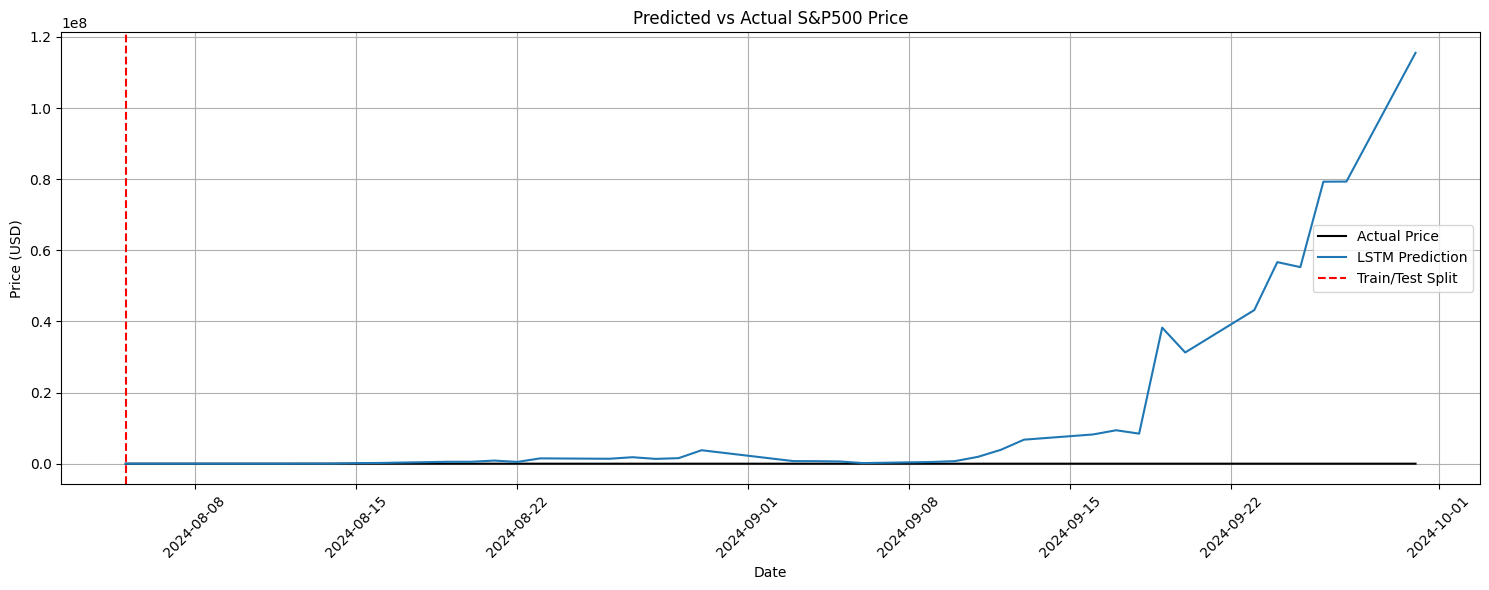

In [2]:
# ---------- 必要なライブラリをColab上でインストール（初回のみ） ----------
!pip install yfinance lightgbm xgboost tensorflow statsmodels -q

# ---------- 各種ライブラリの読み込み ----------
import yfinance as yf  # Yahoo Finance APIを使って株価データを取得
import numpy as np  # 数値計算ライブラリ（行列演算や数学的処理に使用）
import pandas as pd  # データ解析ライブラリ（表形式データの処理に使用）
import warnings  # Pythonの警告を制御（不要な警告を無視するため）
from sklearn.preprocessing import StandardScaler  # データの標準化（スケールを揃える）
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # モデルの評価指標
from sklearn.ensemble import RandomForestRegressor  # ランダムフォレスト（決定木ベースの機械学習モデル）
import lightgbm as lgb  # LightGBM（勾配ブースティングモデル、計算が高速）
import xgboost as xgb  # XGBoost（勾配ブースティングモデル、高精度）
from statsmodels.tsa.arima.model import ARIMA  # ARIMA（時系列予測モデル）
from tensorflow.keras.models import Sequential  # LSTM（ニューラルネットワークモデルを構築）
from tensorflow.keras.layers import LSTM, Dense, Dropout  # LSTMの各層
import tensorflow as tf  # TensorFlow（ディープラーニングフレームワーク）
import matplotlib.pyplot as plt  # グラフ描画ライブラリ（データの可視化）

# ---------- 不要な警告の抑制 ----------
warnings.filterwarnings("ignore", category=FutureWarning)  # 将来の変更による警告を無視
warnings.filterwarnings("ignore", category=UserWarning)  # 一般的なユーザー警告を無視

# ---------- データ取得 ----------
data = yf.download("^GSPC", start="2016-10-01", end="2024-10-01")  # 株価データを取得
data['Log_Close'] = np.log(data['Close'])  # 終値を対数変換（変動率を扱いやすくするため）
data['Log_Return'] = data['Log_Close'].diff()  # 対数変換した終値の差分を計算
data['SMA_20'] = data['Close'].rolling(window=20).mean()  # 20日移動平均を算出（トレンドの把握）
data['RSI_14'] = 100 - (100 / (1 + data['Close'].pct_change().rolling(window=14).mean()))  # RSI（相対力指数）
data['Daily_Change'] = data['Close'].pct_change()  # 日次の変化率
data.dropna(inplace=True)  # 計算できない行を削除（NaNを取り除く）

# ---------- 特徴量の標準化 ----------
features = ['Log_Return', 'High', 'Low', 'Volume', 'SMA_20', 'RSI_14', 'Daily_Change']  # 学習に使う特徴量
scaler = StandardScaler()  # 標準化オブジェクトを作成
scaled_data = scaler.fit_transform(data[features])  # データを標準化（平均0・分散1にする）

# ---------- データ分割 ----------
train_size = int(len(scaled_data) * 0.98)  # データの98%を学習用にし、残りをテスト用に分割
X_train, X_test = scaled_data[:train_size], scaled_data[train_size:]  # 特徴量の分割
y_train, y_test = X_train[:, 0], X_test[:, 0]  # 目的変数（終値の変化率）

# ---------- モデル用データ変形 ----------
X_train_flat, X_test_flat = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)  # 形を整える

# ---------- 結果保存用の辞書 ----------
results = {}  # 各モデルの評価結果を保存
logreturn_preds = {}  # 各モデルの予測値を保存

'''
# ---------- LightGBM ----------
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=15, verbose=-1)  # 計算が高速な回帰モデル
lgb_model.fit(X_train_flat, y_train)  # 学習を実行
logreturn_preds['LightGBM'] = lgb_model.predict(X_test_flat)  # 予測結果を保存

# ---------- XGBoost ----------
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=15, objective='reg:squarederror', verbosity=0) # 回帰モデル
xgb_model.fit(X_train_flat, y_train) # 学習を実行
logreturn_preds['XGBoost'] = xgb_model.predict(X_test_flat) # 予測結果を保存

# ---------- Random Forest ----------
rf_model = RandomForestRegressor(n_estimators=500, max_depth=15) # 回帰モデル
rf_model.fit(X_train_flat, y_train) # 学習を実行
logreturn_preds['RandomForest'] = rf_model.predict(X_test_flat) # 予測結果を保存
'''

# ---------- LSTM ----------
tf.random.set_seed(42)  # 乱数の再現性を確保（結果を安定させる）
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # LSTM層（時間の依存関係を考慮）
    Dropout(0.2),  # 過学習を防ぐためのドロップアウト（一定割合のノードを無効化）
    LSTM(75, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),  # 活性化関数ReLUを用いた全結合層（複雑な関係を捉える）
    Dense(1)  # 最終的な出力層
])
lstm_model.compile(optimizer='adam', loss='mse')  # Adamオプティマイザを使用（収束が速く安定）
lstm_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, epochs=30, batch_size=32, verbose=0)
lstm_preds = lstm_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
logreturn_preds['LSTM'] = lstm_preds.flatten()

'''
# ---------- ARIMA モデル ----------
arima_model = ARIMA(data['Log_Return'][:train_size], order=(5,1,0))  # ARIMAモデル（時系列データの傾向を捉える）
arima_fit = arima_model.fit()
arima_preds = arima_fit.forecast(steps=len(X_test))
logreturn_preds['ARIMA'] = arima_preds.values
'''

# ---------- 評価指標の計算 ----------
for model, preds in logreturn_preds.items():
    mse = mean_squared_error(y_test, preds)  # MSE（平均二乗誤差）：誤差の二乗平均。小さいほど良い
    rmse = np.sqrt(mse)  # RMSE（平方平均二乗誤差）：MSEの平方根。直感的な誤差尺度
    mae = mean_absolute_error(y_test, preds)  # MAE（平均絶対誤差）：予測値と実際の値の平均的なズレ
    mape = np.mean(np.abs((y_test - preds) / (y_test + 1e-8))) * 100  # MAPE（平均絶対パーセント誤差）：相対的な誤差を示す
    r2 = r2_score(y_test, preds)  # R²（決定係数）：モデルの説明力（1に近いほど精度が高い）

    results[model] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'R2': r2
    }  # 各モデルの評価結果を辞書に保存

# ---------- 評価結果の表示 ----------
for model, score in results.items():
    print(f"\n{model} モデルの評価指標（Log Returnベース）:")
    print(f" - MSE（平均二乗誤差）        : {score['MSE']:.8f}")
    print(f" - RMSE（平方平均二乗誤差）   : {score['RMSE']:.8f}")
    print(f" - MAE（平均絶対誤差）        : {score['MAE']:.8f}")
    print(f" - MAPE（平均絶対パーセント誤差）: {score['MAPE (%)']:.2f} %")
    print(f" - R²（決定係数）             : {score['R2']:.8f}")  # モデルごとの評価結果を表示

# ---------- グラフ描画用：価格に再変換 ----------
test_index = data.index[train_size:]  # テストデータの時間軸（日付）
start_price = data['Close'].iloc[train_size]  # 学習データの最後の価格

price_preds = {}  # 各モデルの価格予測を保存

for name, logret in logreturn_preds.items():
    cum_logret = np.cumsum(logret)  # 累積リターンを計算（価格の推移を復元するため）
    pred_len = len(cum_logret)  # 予測データの長さ

    # 長さを調整して範囲エラーを防ぐ
    aligned_index = test_index[:min(len(test_index), pred_len)]

    # start_price を適切な形にしてベクトル演算を可能に
    start_price_vector = np.full(len(aligned_index), np.log(start_price))

    reconstructed_price = np.exp(cum_logret[:len(aligned_index)] + start_price_vector)  # 価格の復元
    price_preds[name] = pd.Series(reconstructed_price, index=aligned_index)  # Seriesに変換して保存

# `actual_price` の長さを `aligned_index` に揃える
actual_price = data['Close'].iloc[train_size:train_size + len(aligned_index)]

# ---------- グラフ描画 ----------
plt.figure(figsize=(15, 6))  # グラフのサイズを指定
plt.plot(actual_price.index, actual_price.values, label='Actual Price', color='black')  # 実際の価格
for name, price in price_preds.items():
    plt.plot(price.index, price.values, label=f'{name} Prediction')  # 各モデルの予測価格をプロット

plt.axvline(actual_price.index[0], color='red', linestyle='dashed', label='Train/Test Split')  # 学習・テストの境界線
plt.title('Predicted vs Actual S&P500 Price')  # グラフタイトル
plt.xlabel('Date')  # X軸ラベル（日時）
plt.ylabel('Price (USD)')  # Y軸ラベル（価格）
plt.xticks(rotation=45)  # X軸のラベルを回転させる（見やすくする）
plt.legend()  # 凡例を追加
plt.grid(True)  # グリッド線を追加
plt.tight_layout()  # レイアウト調整
plt.show()  # グラフを表示
